# PaCMAP Dimension Reduction on CelebA

This notebook will transform the RBG images of the CelebA data set into a 2 dimensional coordinate space that can be plotted in a scatter plot. The transformed data set will then be downloaded as a csv file for easy future uploading without the need to rerun this notebook. 

Due to computational limits, the resolution of these images are first reduced to 64 x 64. Because of this, coupled with the flattening of the image matricies, some important spacial relationships and details may become lost in translation.

The usage of the pacmap package is acredited to https://github.com/YingfanWang/PaCMAP/tree/master.

In [1]:
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pacmap

In [2]:
# ******* Set the directory you wish to store the dataset *******
data_path = '/Users/libbystephan/Documents/School/Stat 424'
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Resize the image to 64x64
    transforms.ToTensor()         # Convert the image to a tensor
])

celebA_dataset = datasets.CelebA(root=data_path, download=False, transform=transform) 

In [3]:
# ------ CONVERT DATASET TO ARRAY FORMAT ------

# pacmap requires ndarray format, with the shape (N, D)
# where N is the number of samples and D is the dimension of each sample

# purpose: convert the tensored dataset into (N, D) array for pacmap use
# input: mnist or celebA dataset, start index of observation, end index of observation (inclusive)
# output: numpy array of converted images, list of attributes for each associated sample
def to_ndarray(dataset, start, end):
    images = []
    attributes = []
    
    for i in range(start, end+1):
        if i >= len(dataset): # stop if out of index
            break
        img = np.array(dataset[i][0]) # Convert image to NumPy array
        img_flat = img.flatten() # Flatten the image
        images.append(img_flat) # Add to list
    
        att = np.array(dataset[i][1])
        attributes.append(att)
    
    return np.array(images), attributes 

In [4]:
#batches for celebA, (it's too big), 162770

celebA_img = []
celebA_att = []
tot_size = len(celebA_dataset)
remaining_size = tot_size
start_i = 0
batch_size = 1000
end_i = start_i+batch_size-1

while (remaining_size >= 0):
    celebA_img.extend(to_ndarray(celebA_dataset, start_i, end_i)[0])
    celebA_att.extend(to_ndarray(celebA_dataset, start_i, end_i)[1])
    print("batch complete, end index: ", end_i)
    remaining_size -= batch_size
    start_i = end_i + 1
    end_i = start_i + batch_size

batch complete, end index:  999
batch complete, end index:  2000
batch complete, end index:  3001
batch complete, end index:  4002
batch complete, end index:  5003
batch complete, end index:  6004
batch complete, end index:  7005
batch complete, end index:  8006
batch complete, end index:  9007
batch complete, end index:  10008
batch complete, end index:  11009
batch complete, end index:  12010
batch complete, end index:  13011
batch complete, end index:  14012
batch complete, end index:  15013
batch complete, end index:  16014
batch complete, end index:  17015
batch complete, end index:  18016
batch complete, end index:  19017
batch complete, end index:  20018
batch complete, end index:  21019
batch complete, end index:  22020
batch complete, end index:  23021
batch complete, end index:  24022
batch complete, end index:  25023
batch complete, end index:  26024
batch complete, end index:  27025
batch complete, end index:  28026
batch complete, end index:  29027
batch complete, end inde

In [5]:
# ------ APPLY PACMAP ------

# fitting on first 3000 images due to computational space limitations
fit_set = celebA_img[0:3000]

# initializing the pacmap instance
# Setting n_neighbors to "None" leads to an automatic choice shown below in "parameter" section
embedding = pacmap.PaCMAP(n_components=2, n_neighbors=None, MN_ratio=0.5, FP_ratio=2.0) 

# Fit the data to subset of data
embedding.fit(fit_set)

# apply fit to all data
celebA_pacmap_img = embedding.transform(celebA_img, basis=fit_set)

In [6]:
# ------ CREATE DATAFRAME FOR PACMAP ------

att_names = [
    "5_o_Clock_Shadow",
    "Arched_Eyebrows",
    "Attractive",
    "Bags_Under_Eyes",
    "Bald",
    "Bangs",
    "Big_Lips",
    "Big_Nose",
    "Black_Hair",
    "Blond_Hair",
    "Blurry",
    "Brown_Hair",
    "Bushy_Eyebrows",
    "Chubby",
    "Double_Chin",
    "Eyeglasses",
    "Goatee",
    "Gray_Hair",
    "Heavy_Makeup",
    "High_Cheekbones",
    "Male",
    "Mouth_Slightly_Open",
    "Mustache",
    "Narrow_Eyes",
    "No_Beard",
    "Oval_Face",
    "Pale_Skin",
    "Pointy_Nose",
    "Receding_Hairline",
    "Rosy_Cheeks",
    "Sideburns",
    "Smiling",
    "Straight_Hair",
    "Wavy_Hair",
    "Wearing_Earrings",
    "Wearing_Hat",
    "Wearing_Lipstick",
    "Wearing_Necklace",
    "Wearing_Necktie",
    "Young"
]


celebA_pacmap = pd.DataFrame(celebA_att, columns = att_names)
celebA_pacmap.insert(0, 'pacmap_x', celebA_pacmap_img[:, 0])
celebA_pacmap.insert(1, 'pacmap_y', celebA_pacmap_img[:, 1])

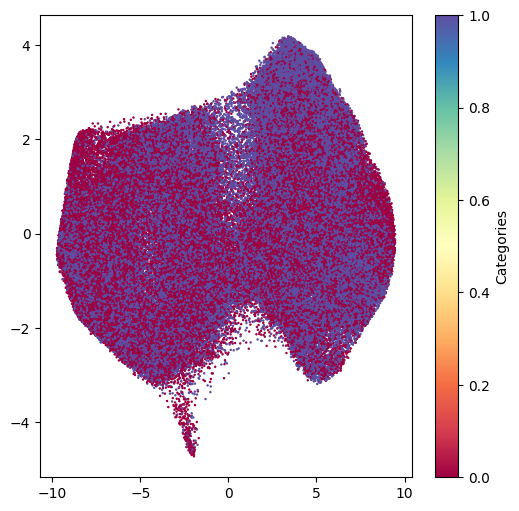

In [16]:
# ----- some small visualizations ----

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
p1 = ax.scatter(celebA_pacmap_img[:, 0], celebA_pacmap_img[:, 1], cmap="Spectral", c=celebA_pacmap["Attractive"],s=0.6)
cbar = plt.colorbar(p1, ax=ax)
cbar.set_label("Categories")  # Set label for colorbar

In [8]:
# --- save as csv ---
celebA_pacmap.to_csv('celebA_pacmap.csv', index=False)